In [94]:
import astropy.io.fits as pf
import pylab as mplot
%pylab inline
from matplotlib.colors import LogNorm
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
import healpy as hp
import numpy as np
from astropy import units as u
from astropy.coordinates import SkyCoord
from scipy import interpolate

Populating the interactive namespace from numpy and matplotlib


In [137]:
ii = '0002'
z = 0.193 #.193
ra_c = 30.0
dec_c = 0.0
nside = 2048
h = 0.7
cd = cosmo.comoving_distance(z)

In [138]:
def M200c_to_R200c(mass, z, cosmo):
    rho_c_z = cosmo.critical_density(z)
    mass_units = mass*u.Msun
    R200c = ((mass_units/(200.*4.*np.pi*rho_c_z/3.))**(1./3.)).to('Mpc') 
    return R200c.value

In [141]:
Rvir = M200c_to_R200c(1.97802e+15/h, z, cosmo)
Rvir_ang = Rvir/(cd.value/(1+z))/np.pi*180
print('R200c', Rvir*h, 'Mpc/h')
print('Rvir', Rvir_ang*60, 'arcmin')
print('R500c', Rvir_ang*60*0.7, 'arcmin')

R200c 1.9160158543546142 Mpc/h
Rvir 14.218822810108328 arcmin
R500c 9.953175967075829 arcmin


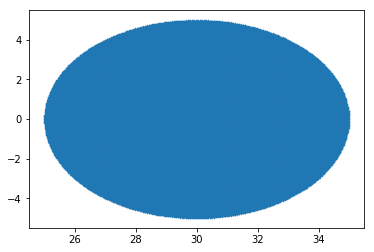

In [78]:
# define grid to work on
healpix_grid = np.arange(hp.nside2npix(nside))
theta, phi = hp.pix2ang(nside, healpix_grid)
ra = phi/np.pi*180
dec = 90.0 - (theta/np.pi*180)

c1 = SkyCoord(ra_c*u.degree, dec_c*u.degree, frame='icrs')
c2 = SkyCoord(ra*u.degree, dec*u.degree, frame='icrs')
sep = c1.separation(c2)
mask_area = (sep.degree<5)
mplot.scatter(ra[mask_area], dec[mask_area], marker='.', s=1)

In [79]:
cluster0 = pf.open('/Users/chihwaychang/Work/300SimSZ/NewMDCLUSTER_'+str(ii)+'/snap_120-TT-z-cl-'+str(int(ii))+'-WV.fits')
cluster_sim = cluster0[0].data

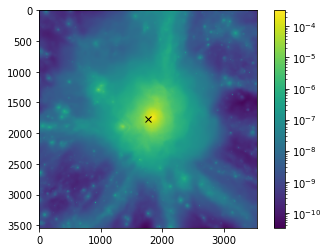

In [80]:
mplot.imshow(cluster0[0].data, norm=LogNorm())
mplot.plot([3542/2],[3542/2], marker='x', color='k')
mplot.colorbar()

In [81]:
# def shrink(data, rows, cols):
#     return data.reshape(rows, int(data.shape[0]/rows), cols, int(data.shape[1]/cols)).sum(axis=1).sum(axis=2)

In [82]:
# new = cluster0[0].data

#shrink(cluster0[0].data, int(3542/2), int(3542/2))
#mplot.imshow(new/16, norm=LogNorm())
#mplot.colorbar()

# Pixel size is 8.382053568392354 kpc (physical units), and 3542x3542 pix
pix_ang = 8.382053568392354/(cd.value*1000/(1+z))
print('each pixel is', pix_ang/np.pi*180*60*60, 'arcsec')
print('full image is', pix_ang/np.pi*180*3542, 'deg on a side')

each pixel is 6.270939301544192 arcsec
full image is 6.169907501685979 deg on a side


peak is in pixel [3.22696094] [3.03877963]


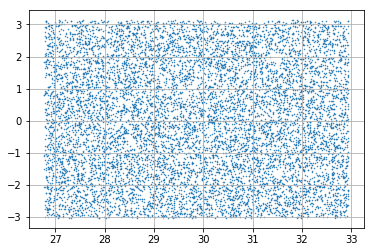

In [83]:
image_size = int(3542)
nx, ny = (image_size, image_size)
x = np.linspace(0, pix_ang/np.pi*180*image_size, nx)
y = np.linspace(0, pix_ang/np.pi*180*image_size, ny)
xv, yv = np.meshgrid(x, y)

peak_pix = (cluster_sim == np.max(cluster_sim))
print('peak is in pixel', xv[peak_pix], yv[peak_pix])

xv = xv - xv[peak_pix] + 30.0
yv = yv - yv[peak_pix] + 0.0
xv = 30 + (xv-30.)*np.cos(yv/180.0*np.pi)

ids = np.arange(len(xv.flatten()))
np.random.shuffle(ids)
mplot.scatter(xv.flatten()[ids[:10000]], yv.flatten()[ids[:10000]], marker='.', s=1, alpha=1)
mplot.grid()

In [84]:
joint_map = np.zeros(hp.nside2npix(nside))
theta = (90.-yv.flatten())/180*np.pi
phi = xv.flatten()/180*np.pi
pix = hp.ang2pix(nside, theta, phi)
unique_pix = np.unique(pix, return_counts=True)[0]
unique_pixN = np.unique(pix, return_counts=True)[1]
map_flat = cluster_sim.flatten()
print(len(unique_pix))
for i in range(len(unique_pix)):
    if i%1000==0: print(i)
    mask_pixi = (pix==unique_pix[i])
    joint_map[unique_pix[i]] = np.mean(map_flat[mask_pixi])

joint_map_smooth = hp.smoothing(joint_map,fwhm=11.0*0.000290888, lmax=2*nside)

46977
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
Sigma is 4.671267 arcmin (0.001359 rad) 
-> fwhm is 10.999992 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [85]:
np.unique(pix, return_counts=True)

(array([23786081, 23786082, 23786083, ..., 26497771, 26497772, 26497773]),
 array([ 79,  96,  97, ..., 109, 109, 110]))

<Figure size 432x288 with 0 Axes>

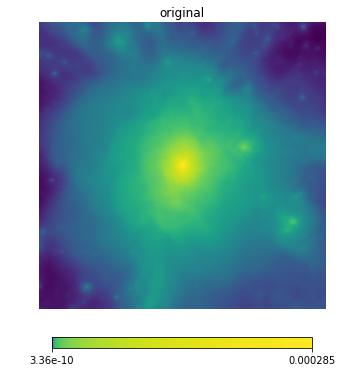

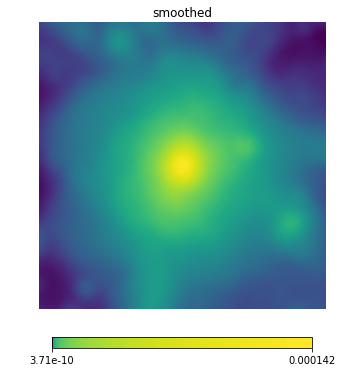

In [144]:
mplot.figure(1)
hp.cartview(joint_map+1e-10, lonra=[28,32], latra=[-2,2], norm=LogNorm(), title='original')
mplot.figure(2)
hp.cartview(joint_map_smooth+1e-10, lonra=[28,32], latra=[-2,2], norm=LogNorm(), title='smoothed')

In [87]:
sz_map = hp.read_map('COM_CompMap_Compton-SZMap-milca-ymaps_2048_R2.00.fits', nest=False)

NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


/Users/chihwaychang/anaconda3/lib/python3.6/site-packages/healpy/fitsfunc.py:326: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  "assume {}".format(schm))


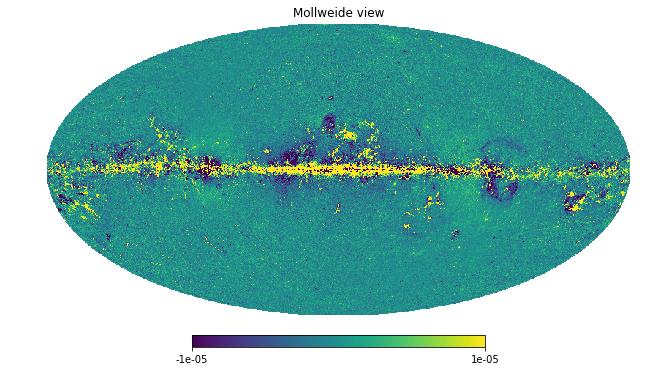

In [88]:
hp.mollview(sz_map, min=-1e-5, max=1e-5)

In [89]:
def rotate_map(hmap, rot_theta, rot_phi):
    """
    Take hmap (a healpix map array) and return another healpix map array 
    which is ordered such that it has been rotated in (theta, phi) by the 
    amounts given.
    """
    nside = hp.npix2nside(len(hmap))

    # Get theta, phi for non-rotated map
    t,p = hp.pix2ang(nside, np.arange(hp.nside2npix(nside))) #theta, phi

    # Define a rotator
    r = hp.Rotator(deg=False, rot=[rot_phi,rot_theta])

    # Get theta, phi under rotated co-ordinates
    trot, prot = r(t,p)

    # Interpolate map onto these co-ordinates
    rot_map = hp.get_interp_val(hmap, trot, prot)

    return rot_map

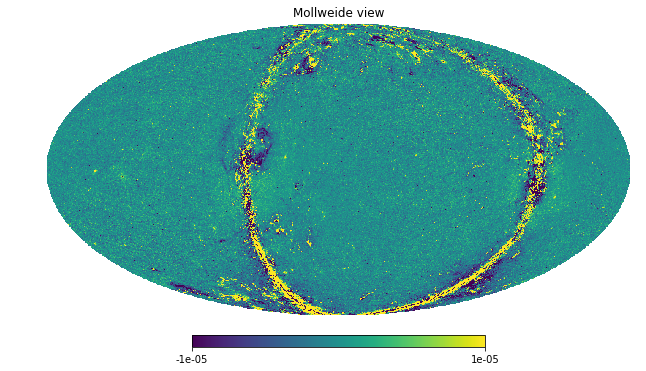

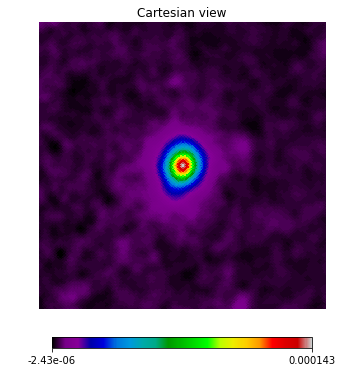

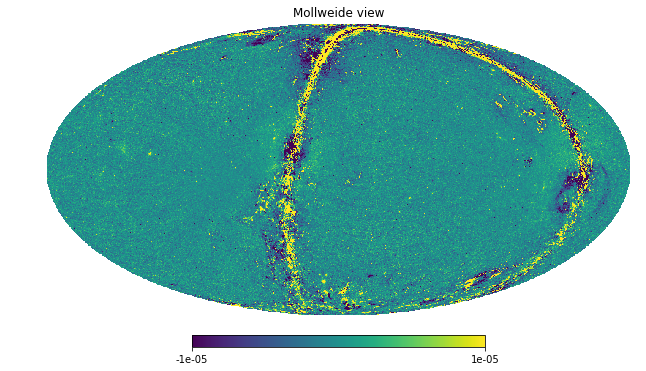

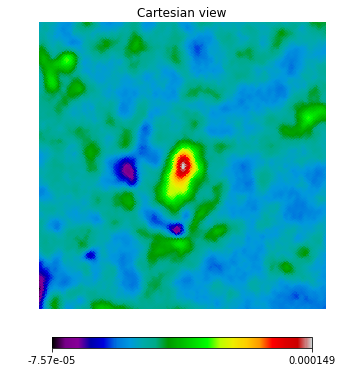

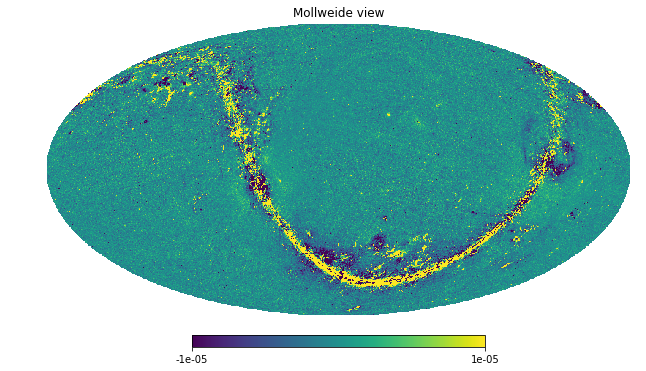

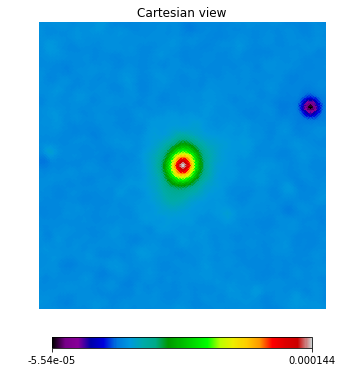

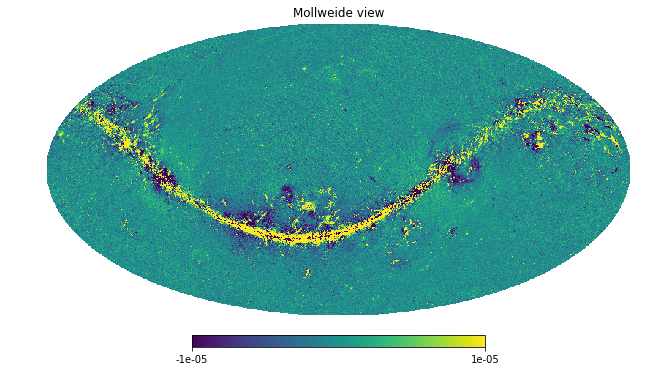

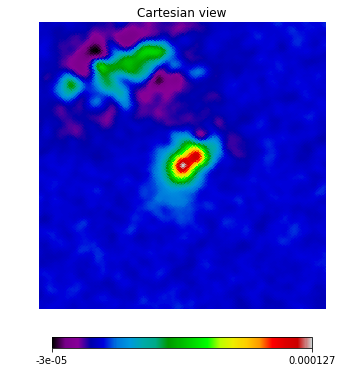

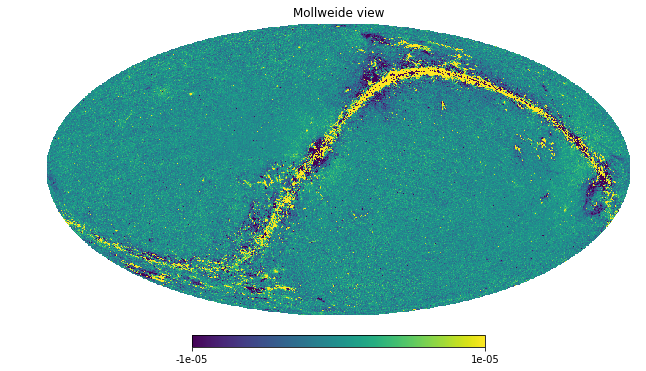

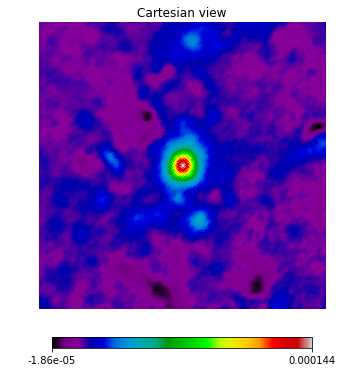

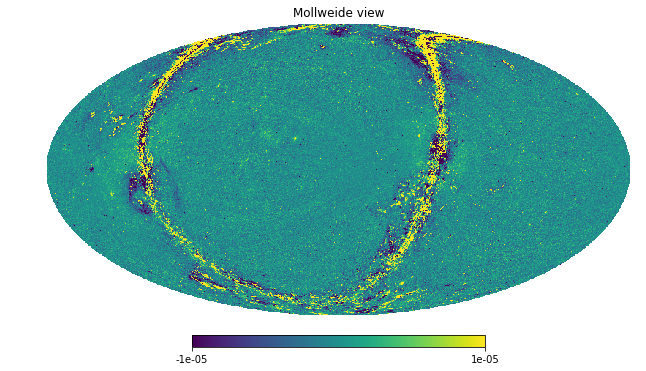

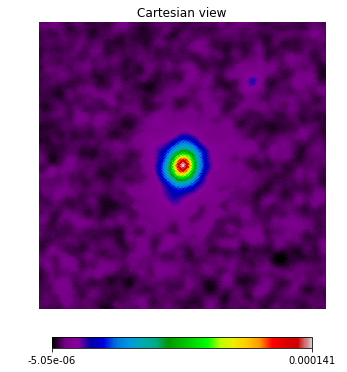

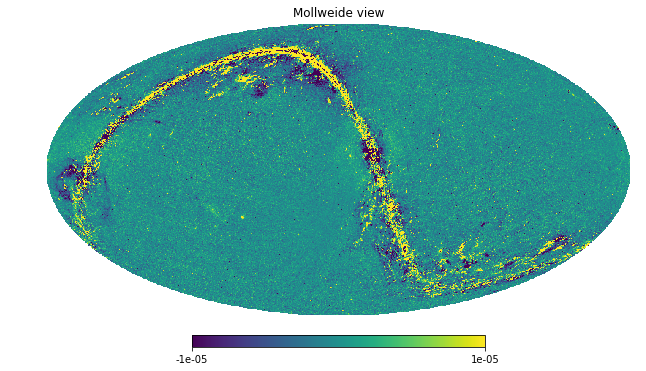

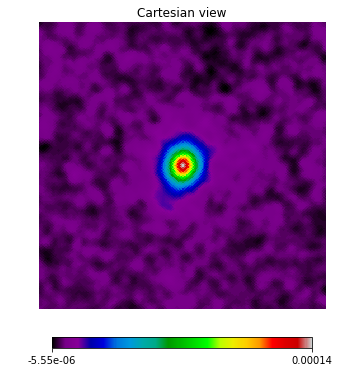

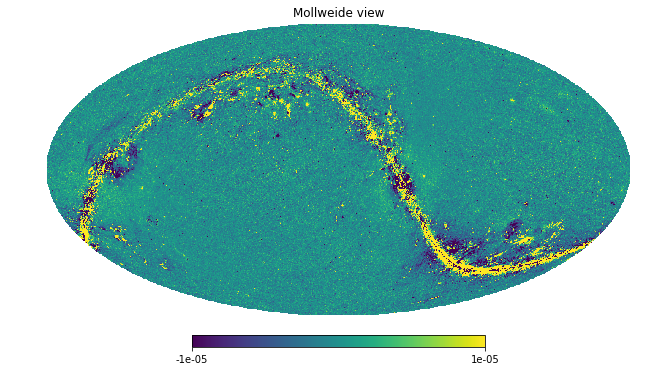

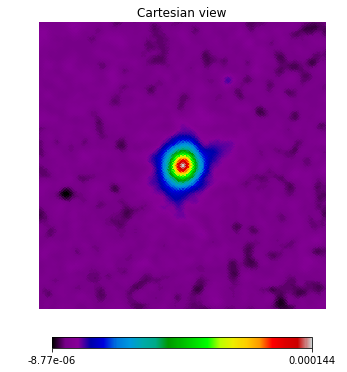

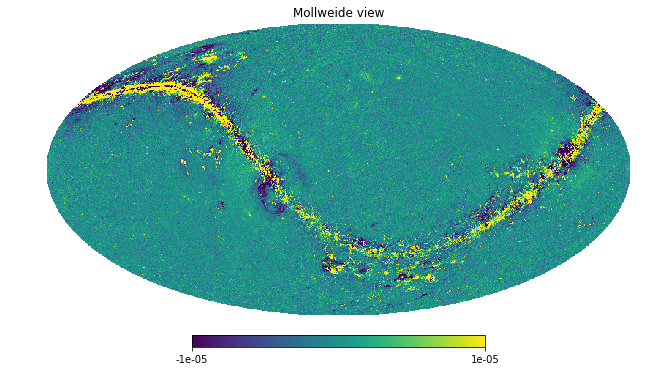

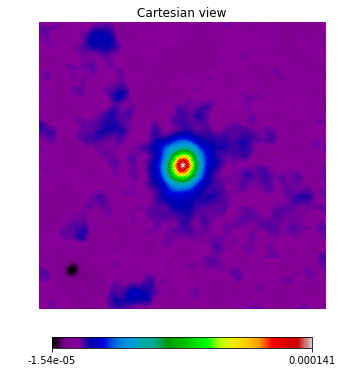

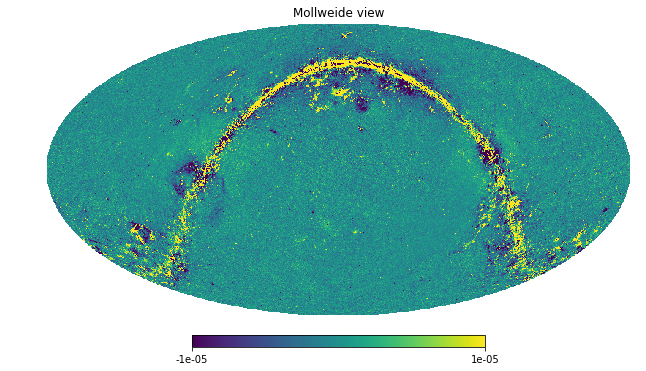

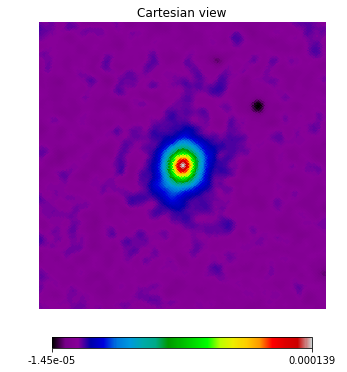

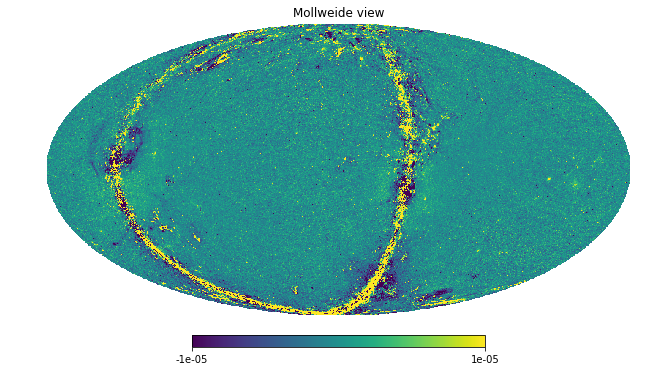

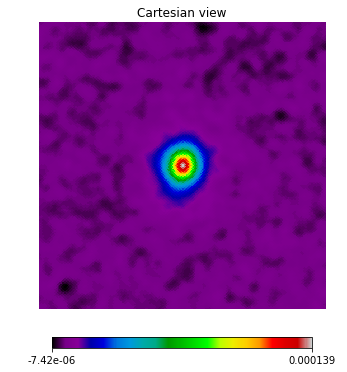

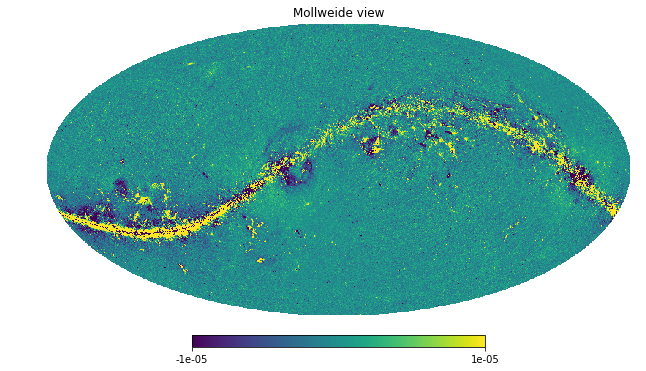

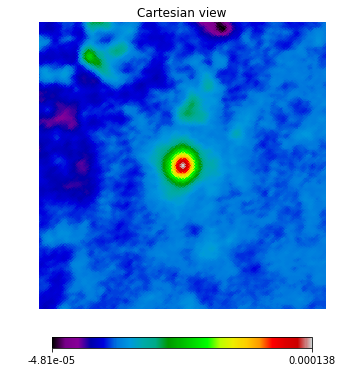

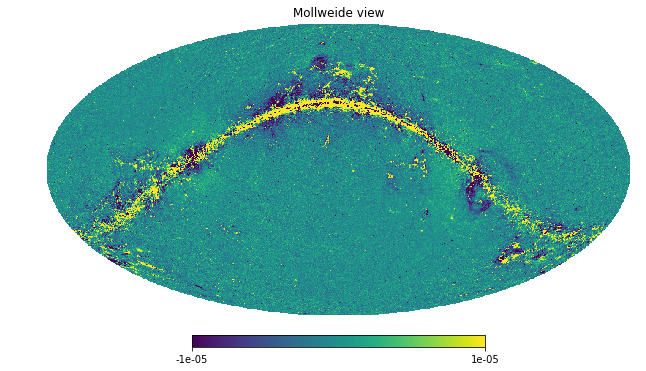

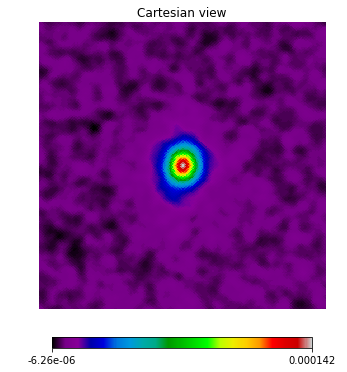

In [90]:
n = 0
for i in range(15):
    rot_theta = 2*np.pi*np.random.random() - np.pi
    rot_phi = 2*np.pi*np.random.random()
    if np.abs(rot_theta)>np.pi/6:
        rot = rotate_map(sz_map, rot_theta, rot_phi)
        hp.mollview(rot, min=-1e-5, max=1e-5)
        mplot.show()
        hp.cartview(joint_map_smooth+rot, lonra=[28,32], latra=[-2,2],cmap='nipy_spectral')
        mplot.show()
        np.savez('rot_Planck_map_'+str(n)+'.npz', map=rot)
        n+=1
    else:
        continue

/Users/chihwaychang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/chihwaychang/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


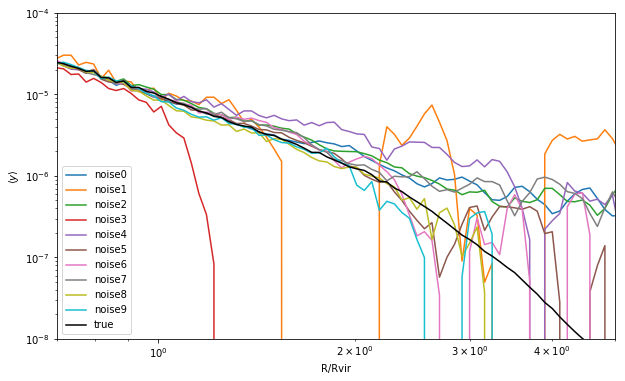

In [91]:
mplot.figure(figsize=(10,6))

c1 = SkyCoord(30.0*u.degree, 0.0*u.degree, frame='icrs')
sep = c1.separation(c2)
mask_cluster = (sep.degree<5)
c2 = SkyCoord(ra*u.degree, dec*u.degree, frame='icrs')
bin_edge = np.logspace(np.log10(0.05), np.log10(10.0), num=201)
bin_min = bin_edge[:-1]
bin_max = bin_edge[1:]

Y1_all = []
for i in range(10):
    tot_map = np.load('rot_Planck_map_'+str(i)+'.npz')['map'] + joint_map_smooth

    Y1 = []
    for k in range(200):
        R_over_R500 = np.array(sep.degree[mask_cluster])/Rvir_ang
        mask = (R_over_R500 >= bin_min[k])*(R_over_R500 < bin_max[k])
        Y1.append(np.median(tot_map[mask_cluster][mask]))
    Y1 = np.array(Y1)
    Y1_all.append(Y1)
    DD = (bin_min+bin_max)/2
    mplot.plot(DD, Y1, label='noise'+str(i))

tot_map = joint_map_smooth*1.0

Y1 = []
for k in range(200):
    R_over_R500 = np.array(sep.degree[mask_cluster])/Rvir_ang
    mask = (R_over_R500 >= bin_min[k])*(R_over_R500 < bin_max[k])
    Y1.append(np.median(tot_map[mask_cluster][mask]))
Y1 = np.array(Y1)

mplot.plot(DD, Y1, color='k', label='true')

mplot.ylabel('$\langle y \\rangle$')
mplot.xlabel('R/Rvir')
mplot.yscale('log')
mplot.xscale('log')
mplot.xlim(0.7,5)
mplot.ylim(1e-8, 1e-4)
mplot.legend()

/Users/chihwaychang/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: Invalid value encountered in median for 43 results
  r = func(a, **kwargs)


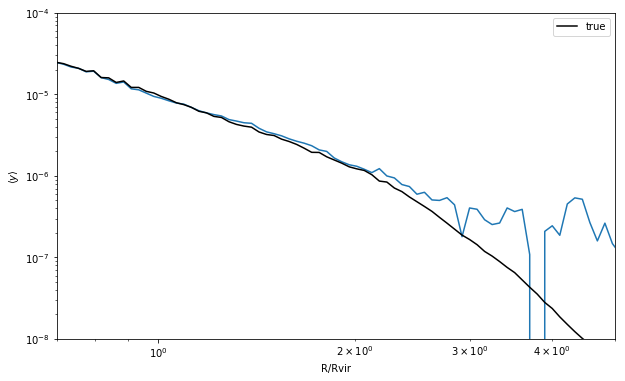

In [92]:
mplot.figure(figsize=(10,6))

Y1_all = np.array(Y1_all)
mplot.plot(DD, np.median(Y1_all, axis=0))
mplot.plot(DD, Y1, color='k', label='true')

mplot.ylabel('$\langle y \\rangle$')
mplot.xlabel('R/Rvir')
mplot.yscale('log')
mplot.xscale('log')
mplot.xlim(0.7,5)
mplot.ylim(1e-8, 1e-4)
mplot.legend()

In [ ]:
# try SPT noise and beam?